In [2]:
%matplotlib inline

import warnings
from pathlib import Path
import os
from datetime import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from statsmodels.api import OLS, add_constant
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.externals import joblib

In [3]:
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
np.random.seed(42)

In [4]:
with pd.HDFStore('model_tuning.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: model_tuning.h5
/catboost/factors/results             frame        (shape->[96,64])   
/holdout/features                     frame        (shape->[16695,84])
/holdout/target                       series       (shape->[16695])   
/lightgbm/dummies/results             frame        (shape->[396,29])  
/lightgbm/factors/results             frame        (shape->[396,29])  
/lightgbm/holdout/features            frame        (shape->[16695,84])
/lightgbm/holdout/target              series       (shape->[16695])   
/xgboost/dummies/results              frame        (shape->[216,20])  
/xgboost/holdout/features             frame        (shape->[16695,84])
/xgboost/holdout/target               series       (shape->[16695])   


## Keep only parameters used for grid search

In [34]:
with pd.HDFStore('model_tuning.h5') as source:
    print(source.info())
    with pd.HDFStore('results.h5') as target:
        results = [k for k in source.keys() if k.endswith('results')]
        for result in results:
            df = source[result]

            # drop info that doesn't change across models
            df = df.loc[:, ~df.eq(df.iloc[0, :], axis=1).all()].dropna(how='all', axis=1)
            target.put('/'.join(result[1:].split('/')[:2]),
                           df.sort_values('valid', ascending=False).reset_index(drop=True))

<class 'pandas.io.pytables.HDFStore'>
File path: model_tuning.h5
/catboost/factors/results             frame        (shape->[96,64])   
/holdout/features                     frame        (shape->[16695,84])
/holdout/target                       series       (shape->[16695])   
/lightgbm/dummies/results             frame        (shape->[396,29])  
/lightgbm/factors/results             frame        (shape->[396,29])  
/lightgbm/holdout/features            frame        (shape->[16695,84])
/lightgbm/holdout/target              series       (shape->[16695])   
/xgboost/dummies/results              frame        (shape->[216,20])  
/xgboost/holdout/features             frame        (shape->[16695,84])
/xgboost/holdout/target               series       (shape->[16695])   


In [35]:
with pd.HDFStore('results.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: results.h5
/catboost/factors            frame        (shape->[96,9]) 
/lightgbm/dummies            frame        (shape->[1,14]) 
/lightgbm/factors            frame        (shape->[1,14]) 
/xgboost/dummies             frame        (shape->[216,9])


## Validation Performance

### All models

In [112]:
with pd.HDFStore('results.h5') as store:
    for key in store.keys()[:1]:
        df = store[key].sort_values('valid', ascending=False)
        print('\n', key.split('/')[1])
        print(df.head())
        df.iloc[0].to_csv('catboost_best.csv')


 catboost
      rounds     train     valid  max_depth  max_bin  max_ctr_complexity  \
0  22.333333  0.736140  0.687047         12      128                   2   
1  35.500000  0.754037  0.686918          9       32                   3   
2  25.500000  0.727976  0.684795          6      128                   2   
3  13.750000  0.731933  0.684578          9       32                   2   
4  18.833333  0.733755  0.684223          9      128                   2   

   one_hot_max_size  random_strength        time  
0               2.0              1.0  229.663642  
1               NaN              1.0   83.367715  
2               NaN              1.0  111.405799  
3               2.0              1.0   62.510955  
4               2.0              1.0  125.536569  


In [44]:
models = ['catboost/factors', 'lightgbm/dummies', 'lightgbm/factors', 'xgboost/dummies']
df = pd.DataFrame()
with pd.HDFStore('results.h5') as store:
    for k in models:
        model = k.split('/')[0]
        data = k.split('/')[1]
        df = pd.concat([df, store[k][['train', 'valid', 'time']].assign(model=model, data=data)])
df['Model'] = df.model.str.capitalize().str.cat(df.data.str.capitalize(), sep=' ')        
df = df.drop(['model', 'data'], axis=1).rename(columns={'valid': 'Validation AUC'})
df.info()    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1104 entries, 0 to 215
Data columns (total 4 columns):
train             1104 non-null float64
Validation AUC    1104 non-null float64
time              1104 non-null float64
Model             1104 non-null object
dtypes: float64(3), object(1)
memory usage: 43.1+ KB


In [62]:
top_scores = df.groupby('Model')['Validation AUC'].max().sort_values(ascending=False).to_dict()

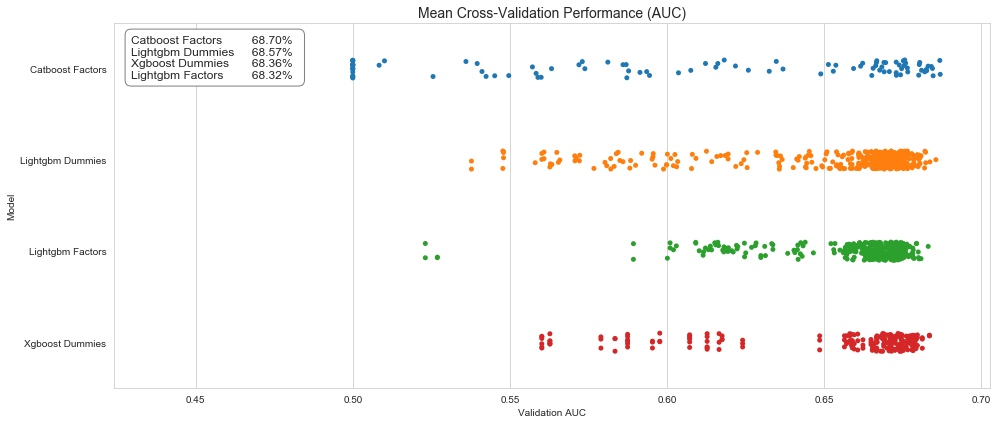

In [89]:
plt.figure(figsize=(14,6))
ax = sns.stripplot(x='Validation AUC', y='Model', data=df)
ax.set_title('Mean Cross-Validation Performance (AUC)', fontsize=14)
ax.text(x=.02, y=.85, s='\n'.join([f'{m:<35}' for m, s in top_scores.items()]),
            transform=ax.transAxes, fontsize=12, 
            bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.5'))
ax.text(x=.15, y=.85, s='\n'.join([f'{s:>8.2%}' for m, s in top_scores.items()]),
            transform=ax.transAxes, fontsize=12)
plt.tight_layout();

## Combine Model Results

In [102]:
cols = ['model', 'data', 'train', 'valid', 'boosting', 'learning_rate', 'max_depth', 'num_leaves',
        'colsample_bytree', 'min_gain_to_split', 'rounds', 'time']

with pd.HDFStore('results.h5') as store:
    xgb = store['xgboost/dummies'].rename(columns={'booster': 'boosting', 'gamma': 'min_gain_to_split'}).assign(
        model='xgb', data='dummies')

    lgb_dummies = store['lightgbm/dummies'].assign(
        model='lightgbm', data='dummies')
    lgb_dummies.boosting = lgb_dummies.boosting.str.replace('gbdt', 'gbtree')

    lgb_factors = store['lightgbm/factors'].assign(
        model='lightgbm', data='factors')

lgb_xgb_combined = (lgb_dummies
                    .append(lgb_factors)
                    .append(xgb, ignore_index=True)).loc[:, cols]

lgb_xgb_combined['model_type'] = lgb_xgb_combined.model.str.capitalize(
).str.cat(lgb_xgb_combined.data.str.capitalize(), sep=' ')
lgb_xgb_combined = lgb_xgb_combined.drop(['model', 'data'], axis=1)

lgb_xgb_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 11 columns):
train                1008 non-null float64
valid                1008 non-null float64
boosting             1008 non-null object
learning_rate        1008 non-null float64
max_depth            1008 non-null int64
num_leaves           792 non-null float64
colsample_bytree     1008 non-null float64
min_gain_to_split    1008 non-null int64
rounds               1008 non-null float64
time                 1008 non-null float64
model_type           1008 non-null object
dtypes: float64(7), int64(2), object(2)
memory usage: 86.7+ KB


### Best Performing Models

In [103]:
lgb_xgb_combined.sort_values('valid', ascending=False).head(10)

,train,valid,boosting,learning_rate,max_depth,num_leaves,colsample_bytree,min_gain_to_split,rounds,time,model_type
0,0.823529,0.685673,gbtree,0.1,13,8192.0,0.8,0,44.416667,86.548636,Lightgbm Dummies
1,0.803322,0.683760,gbtree,0.1,12,4096.0,0.8,0,34.916667,63.578490,Lightgbm Dummies
792,0.798142,0.683618,gbtree,0.1,9,NaN,1.0,1,59.166667,85.372013,Xgb Dummies
793,0.798142,0.683618,gbtree,0.1,9,NaN,1.0,5,59.166667,94.299514,Xgb Dummies
794,0.798142,0.683618,gbtree,0.1,9,NaN,1.0,0,59.166667,75.323257,Xgb Dummies
396,0.721158,0.683226,gbdt,0.3,3,8.0,1.0,0,41.000000,18.782672,Lightgbm Factors
2,0.801764,0.682428,gbtree,0.1,11,2048.0,1.0,0,53.916667,71.732526,Lightgbm Dummies
3,0.785657,0.682390,dart,0.1,13,8192.0,1.0,0,54.166667,171.725467,Lightgbm Dummies
4,0.729307,0.682187,gbtree,0.3,7,128.0,0.6,5,18.833333,15.769092,Lightgbm Dummies
5,0.774811,0.682066,gbtree,0.1,9,512.0,0.8,0,53.916667,46.393234,Lightgbm Dummies


In [104]:
lgb_xgb_combined.groupby('model_type').apply(lambda x: x.sort_values('valid', ascending=False).head(1)).reset_index(-1, drop=True).T.to_csv('best_models.csv')

### Decision Tree for all models

In [105]:
reg_tree = DecisionTreeRegressor(criterion='mse',
                                 splitter='best',
                                 min_samples_split=2,
                                 min_samples_leaf=2,
                                 min_weight_fraction_leaf=0.0,
                                 max_features=None,
                                 random_state=42,
                                 max_leaf_nodes=None,
                                 min_impurity_decrease=0.0,
                                 min_impurity_split=None,
                                 presort=False)

In [106]:
feature_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 38 columns):
boosting_dart                  1008 non-null uint8
boosting_gbdt                  1008 non-null uint8
boosting_gbtree                1008 non-null uint8
learning_rate_0.01             1008 non-null uint8
learning_rate_0.1              1008 non-null uint8
learning_rate_0.3              1008 non-null uint8
max_depth_3                    1008 non-null uint8
max_depth_4                    1008 non-null uint8
max_depth_5                    1008 non-null uint8
max_depth_6                    1008 non-null uint8
max_depth_7                    1008 non-null uint8
max_depth_8                    1008 non-null uint8
max_depth_9                    1008 non-null uint8
max_depth_10                   1008 non-null uint8
max_depth_11                   1008 non-null uint8
max_depth_12                   1008 non-null uint8
max_depth_13                   1008 non-null uint8
num_leaves_-1.0           

In [107]:
test_score = lgb_xgb_combined.valid
feature_data = lgb_xgb_combined.drop(['train', 'valid', 'time', 'rounds'], axis=1).fillna(-1)
feature_data = pd.get_dummies(feature_data, columns=feature_data.columns)
features = feature_data.columns
reg_tree.fit(X=feature_data, y=test_score)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

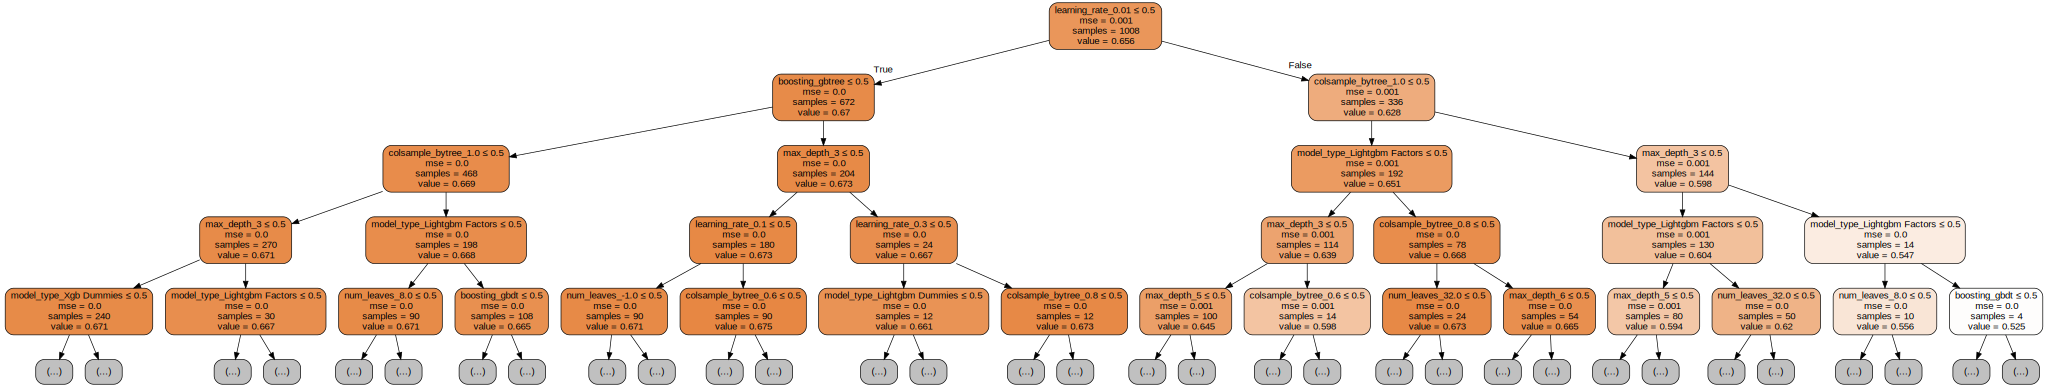

In [108]:
# out_file = 'model_tuning/xgb_tree.dot'
out_file = None
dot_data = export_graphviz(reg_tree,
                          out_file=out_file,
                          feature_names=features,
                          max_depth=4,
                          filled=True,
                          rounded=True,
                          special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

In [109]:
pd.Series(reg_tree.feature_importances_, index=features).sort_values(ascending=False)

learning_rate_0.01             0.435011
colsample_bytree_1.0           0.250942
max_depth_3                    0.077323
model_type_Lightgbm Factors    0.070071
max_depth_5                    0.041259
colsample_bytree_0.6           0.027643
num_leaves_16.0                0.014961
max_depth_4                    0.009869
max_depth_7                    0.008298
boosting_dart                  0.007767
num_leaves_64.0                0.005934
max_depth_8                    0.005748
colsample_bytree_0.8           0.003780
num_leaves_32.0                0.003572
max_depth_6                    0.003517
boosting_gbtree                0.003484
learning_rate_0.3              0.003010
learning_rate_0.1              0.002892
num_leaves_512.0               0.002625
num_leaves_1024.0              0.002286
max_depth_13                   0.002278
num_leaves_8.0                 0.002136
min_gain_to_split_5            0.002080
max_depth_11                   0.001636
boosting_gbdt                  0.001479


## XGB Parameter Usage

In [6]:
reg_tree = DecisionTreeRegressor(criterion='mse',
                                 splitter='best',
                                 max_depth=4,
                                 min_samples_split=5,
                                 min_samples_leaf=10,
                                 min_weight_fraction_leaf=0.0,
                                 max_features=None,
                                 random_state=42,
                                 max_leaf_nodes=None,
                                 min_impurity_decrease=0.0,
                                 min_impurity_split=None,
                                 presort=False)

In [8]:
xgb_data = df[(df.model_type=='Xgb Dummies')]
xgb_data.boosting = pd.factorize(xgb_data.boosting)[0]
xgb_features = ['boosting', 'learning_rate', 'max_depth', 'colsample_bytree', 'min_gain_to_split']
reg_tree.fit(X=xgb_data[xgb_features], y=xgb_data.valid)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

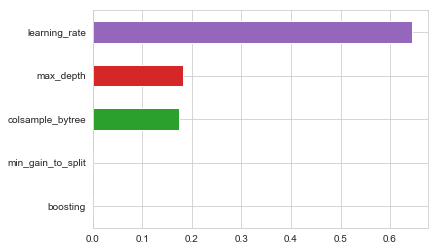

In [9]:
pd.Series(reg_tree.feature_importances_, index=xgb_features).sort_values().plot.barh();

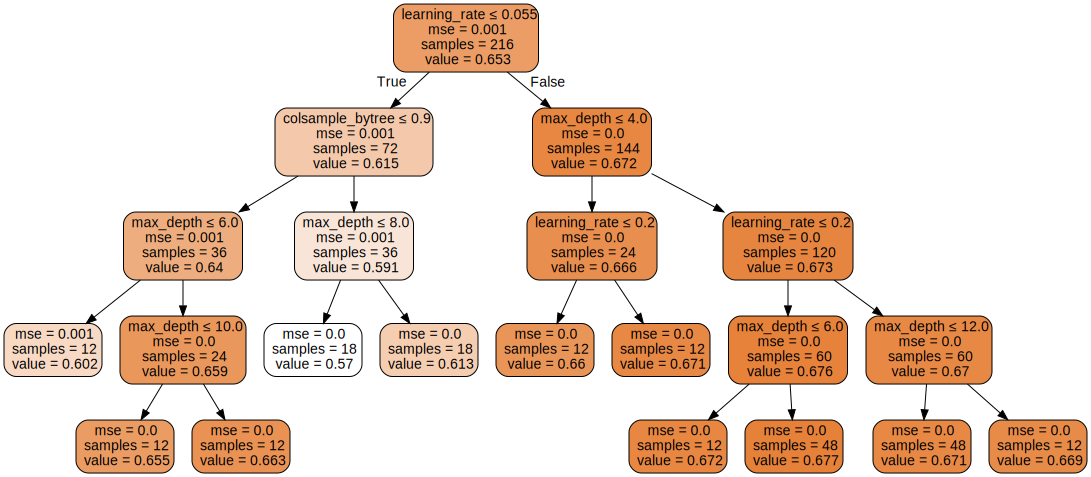

In [10]:
out_file = 'model_tuning/xgb_tree.dot'
dot_data = export_graphviz(reg_tree,
                          out_file=out_file,
                          feature_names=xgb_features,
                          max_depth=4,
                          filled=True,
                          rounded=True,
                          special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

## Overall Validation Performance

In [110]:
models = ['catboost/factors', 'lightgbm/dummies', 'lightgbm/factors', 'xgboost/dummies']
df = pd.DataFrame()
with pd.HDFStore('results.h5') as store:
    for k in models:
        model = k.split('/')[0]
        data = k.split('/')[1]
        df = pd.concat([df, store[k][['train', 'valid', 'time']].assign(model=model, data=data)])
df['Model'] = df.model.str.capitalize().str.cat(df.data.str.capitalize(), sep=' ')        
df = df.drop(['model', 'data'], axis=1).rename(columns={'valid': 'Validation AUC'})
df.info()    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1104 entries, 0 to 215
Data columns (total 4 columns):
train             1104 non-null float64
Validation AUC    1104 non-null float64
time              1104 non-null float64
Model             1104 non-null object
dtypes: float64(3), object(1)
memory usage: 43.1+ KB


### LightGBM vs XGBoost

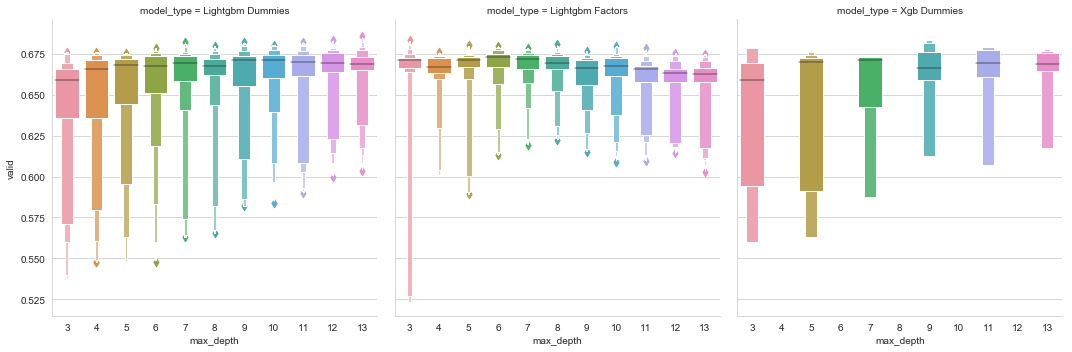

In [113]:
sns.catplot(x='max_depth', y='valid', col='model_type', data=lgb_xgb_combined, kind='boxen');

In [116]:
features = ['boosting','learning_rate', 'max_depth', 'colsample_bytree', 'min_gain_to_split']
path = Path('ols_results')
for model, data in lgb_xgb_combined.groupby('model_type'):
    y = data.valid 
    X = pd.get_dummies(data[features].dropna(how='all', axis=1), columns=features, drop_first=True)
    ols = OLS(endog=y, exog=add_constant(X)).fit(cov_type='HC3')
    print('\n', model)
    print(ols.summary())
    plt.rc('figure', figsize=(12, 7))
    plt.text(0.01, 0.05, str(ols.summary()), {'fontsize': 14}, fontproperties = 'monospace')
    plt.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.1)
    plt.savefig(path / f'{model}.png', bbox_inches='tight', dpi=300)
    plt.close();    


 Lightgbm Dummies
                            OLS Regression Results                            
Dep. Variable:                  valid   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     26.94
Date:                Wed, 24 Oct 2018   Prob (F-statistic):           7.92e-55
Time:                        14:03:45   Log-Likelihood:                 1018.7
No. Observations:                 396   AIC:                            -2001.
Df Residuals:                     378   BIC:                            -1930.
Df Model:                          17                                         
Covariance Type:                  HC3                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const        

### CatBoost

In [85]:
cat_features = ['max_depth', 'max_bin', 'max_ctr_complexity',  'one_hot_max_size',  'random_strength']
with pd.HDFStore('results.h5') as store:
    cat_data = store['catboost/factors']
cat_data.info()    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96 entries, 0 to 95
Data columns (total 9 columns):
rounds                96 non-null float64
train                 96 non-null float64
valid                 96 non-null float64
max_depth             96 non-null int64
max_bin               96 non-null int64
max_ctr_complexity    96 non-null int64
one_hot_max_size      48 non-null float64
random_strength       48 non-null float64
time                  96 non-null float64
dtypes: float64(6), int64(3)
memory usage: 7.5 KB


In [90]:
reg_tree.fit(X=cat_data[cat_features].fillna(-1), y=cat_data.valid)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

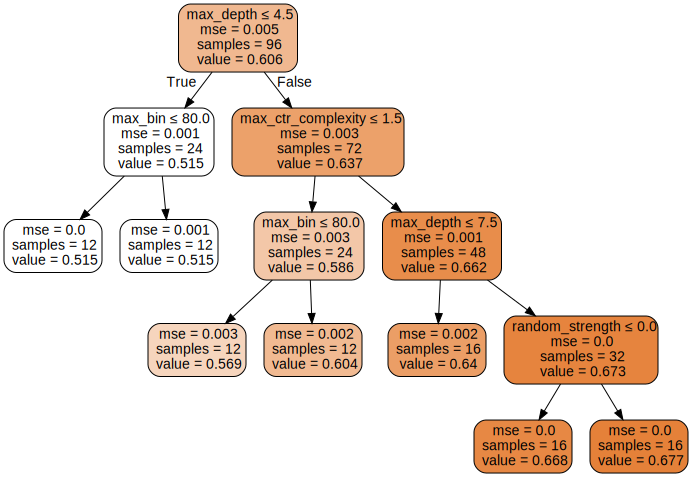

In [91]:
out_file = 'model_tuning/cat_tree.dot'
dot_data = export_graphviz(reg_tree,
                          out_file=out_file,
                          feature_names=cat_features,
                          max_depth=4,
                          filled=True,
                          rounded=True,
                          special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)